# Autoencoder for credit card detection (Pytorch)

See example here: 

* This example: https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras/blob/master/fraud_detection.ipynb

* Another example: https://github.com/GitiHubi/deepAI/blob/master/GTC_2018_Lab.ipynb


## Setup

In [1]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np

import seaborn as sns

from random import randint
from scipy import stats
from sklearn.utils import shuffle
from sklearn.neighbors import NearestNeighbors

import pandas as pd
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, QuantileTransformer, MaxAbsScaler

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F

import sys
print(sys.version)

print(torch.version)
print('cuda:',torch.version.cuda)

# Choose cpu/gpu
use_gpu=1
if (use_gpu):
    print('\nEnable gpu')
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda") # Uncomment this to run on GPU
    
else:
    print('\nRun on cpu')
    dtype = torch.FloatTensor
    device = torch.device("cpu")


3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]
<module 'torch.version' from '/home/donini/anaconda3/lib/python3.6/site-packages/torch/version.py'>
cuda: 9.0.176

Enable gpu


## Get Data

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud/home). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [2]:
df = pd.read_csv("data/creditcard.csv")
signal_all = df[df['Class']==1]
background_all = df[df['Class']==0]

## Event selection
Apply loose cuts to remove outliers

## Construct x_train and x_test_signal samples (BG + frac signal)

In [3]:
# choose data features
#---------------------

# Choose all
signal_sel     = signal_all.iloc[:,:]
background_sel = background_all.iloc[:,:]

# Choose selected features
#features=['pt1', 'eta1', 'phi1', 'E1', 'pt2', 'eta2', 'phi2', 'E2']
#signal_sel = signal_all.loc[:,features]
#background_sel = background_all.loc[:,features]

# Optional: drop columns
drop=['Class']
signal_sel = signal_sel.drop(columns=drop)
background_sel = background_sel.drop(columns=drop)

# Construct x_train and x_test_signal samples (BG + frac signal)
#-------------------------------------------------------------
back = shuffle(background_sel)
sig  = shuffle(signal_sel)

varname = list(signal_sel)

Nb = back.shape[0]//2
Ns = sig.shape[0]

x_train = back[0:Nb]
x_test_back = back[Nb+1:]
x_test_signal = sig

print('bg all=', background_all.shape, 'sig all=', signal_all.shape, 'x_train=', x_train.shape,  'x_test_back=', x_test_back.shape, 'x_test_signal=', x_test_signal.shape)


bg all= (284315, 31) sig all= (492, 31) x_train= (142157, 30) x_test_back= (142157, 30) x_test_signal= (492, 30)


### Look at data

## Rescale data

In [4]:
# Rescale data
#-------------
scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler = RobustScaler()
#scaler = Normalizer()
#scaler = QuantileTransformer(output_distribution='normal', random_state=0)
#scaler = MaxAbsScaler()

# fit (get min and max) and transform x_train
x_train = scaler.fit_transform(x_train)

# transform x_test (using scale parameters of x_train)
x_test_back = scaler.transform(x_test_back)
x_test_signal = scaler.transform(x_test_signal)

print('Trial sample size: ',x_test_signal.shape)
print('Benchmark sample size: ',x_train.shape)

Trial sample size:  (492, 30)
Benchmark sample size:  (142157, 30)


## Partition training data

In [5]:
# After all of this, it's important to partition the data. In order for your model to generalize well, 
# you split the training data into two parts: a training and a validation set. 
# You will train your model on 80% of the data and validate it on 20% of the remaining training data. 

from sklearn.model_selection import train_test_split

x_train_train,x_train_valid = train_test_split(x_train,test_size=0.2,random_state=13) 
print(x_train_train.shape)
print(x_train_valid.shape)

(113725, 30)
(28432, 30)


# Load the Dataset
We shuffle the loading process of train_dataset to make the learning process independent of data orderness, but the order of test_loader remains to examine whether we can handle unspecified bias order of inputs.

In [6]:
num_epochs = 500
batch_size = 256

# For training
train_loader = torch.utils.data.DataLoader(dataset=x_train_train,
                                          batch_size=batch_size,
                                          shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=x_train_valid,
                                          batch_size=batch_size,
                                          shuffle=True)

# For testing on signal (shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=x_test_signal,
                                          batch_size=batch_size,
                                          shuffle=False)

# For testing on all training sample (shuffle=False)
train_all_loader = torch.utils.data.DataLoader(dataset=x_train,
                                          batch_size=batch_size,
                                          shuffle=False)

# For testing on unseen background sample (shuffle=False)
test_bg_loader = torch.utils.data.DataLoader(dataset=x_test_back,
                                          batch_size=batch_size,
                                          shuffle=False)


# AutoEncoder model

picked from here: https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/simple_autoencoder.py

## Deep version

In [7]:
input_dim = x_train.shape[1]
hidden_layer1 = 50
hidden_layer2 = 50
encoding_dim = 15

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_layer1),
            nn.Sigmoid(),
            nn.Linear(hidden_layer1, hidden_layer2),
            nn.Sigmoid(),
            nn.Linear(hidden_layer2, encoding_dim),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_layer2),
            nn.Sigmoid(),
            nn.Linear(hidden_layer2, hidden_layer1),
            nn.Sigmoid(),
            nn.Linear(hidden_layer1,input_dim),
            #nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


### Option: add noise to training data

In [8]:
scale = 0.0

def add_noise(data,scale):
    noise = torch.randn(data.shape) * scale
    noise = noise.type(dtype)
    noisy_data = data + noise
    return noisy_data

def data_with_zeros(data):
    # Set some of the input variables to zero
    # zeros = torch.round(torch.rand(data.shape)*1.49).type(dtype) # tensor with only 0 or 1 values (about 33% are zeros)
    zeros = torch.round(torch.rand(data.shape)).type(dtype) # tensor with only 0 or 1 values (about 50% are zeros)
    return data*zeros

# Training
Notes:

* Implementing own loss-function:
https://cs230-stanford.github.io/pytorch-getting-started.html#loss-function

* About regularization
https://discuss.pytorch.org/t/how-to-create-compound-loss-mse-l1-norm-regularization/17171

epoch [1/500], train loss:0.0046, validation loss:0.0053
epoch [10/500], train loss:0.0023, validation loss:0.0018
epoch [20/500], train loss:0.0017, validation loss:0.0016
epoch [30/500], train loss:0.0019, validation loss:0.0014
epoch [40/500], train loss:0.0015, validation loss:0.0015
epoch [50/500], train loss:0.0010, validation loss:0.0012
epoch [60/500], train loss:0.0010, validation loss:0.0011
epoch [70/500], train loss:0.0009, validation loss:0.0009
epoch [80/500], train loss:0.0008, validation loss:0.0006
epoch [90/500], train loss:0.0006, validation loss:0.0005
epoch [100/500], train loss:0.0005, validation loss:0.0003
epoch [110/500], train loss:0.0005, validation loss:0.0002
epoch [120/500], train loss:0.0003, validation loss:0.0009
epoch [130/500], train loss:0.0003, validation loss:0.0002
epoch [140/500], train loss:0.0003, validation loss:0.0006
epoch [150/500], train loss:0.0005, validation loss:0.0003
epoch [160/500], train loss:0.0002, validation loss:0.0003
epoch [1

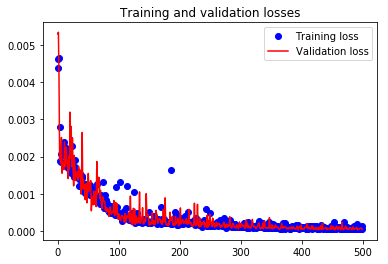

In [9]:
# Settings
if (use_gpu):
    model = autoencoder().cuda() # enable GPU
else:
    model = autoencoder()

# Loss function: https://pytorch.org/docs/master/nn.html#loss-functions
criterion = nn.MSELoss()
#criterion = nn.L1Loss()

# Optimizer: https://pytorch.org/docs/stable/optim.html
learning_rate = 0.001  # default is 0.001
#l2_norm       = 1e-3   # L2 norm regularization (0 is no regularization)
l2_norm       = 0   # L2 norm regularization (0 is no regularization)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay = l2_norm)


# Train
train_loss = []
valid_loss = []

for epoch in range(num_epochs):
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data in train_loader:
        data = data.type(dtype)
        
        output = model(data)
        
        # Optional: add noise to input data
        #output = model(torch.clamp(add_noise(data,scale),0,1))
        
        # Optional: set random input variables to zero
        #output = model(data_with_zeros(data))
        
        loss = criterion(output, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    train_loss.append(loss.item())
    #print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))

    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data in valid_loader:
        data = data.type(dtype)
        
        output = model(data)

        # Optional: add noise to input data
        # output = model(torch.clamp(add_noise(data,scale),0,1))
        
        # Optional: set random input variables to zero
        #output = model(data_with_zeros(data))

        loss = criterion(output, data)
    # record validation loss
    valid_loss.append(loss.item())    
    
    if (epoch==0 or (epoch+1)%10==0):
        print('epoch [{}/{}], train loss:{:.4f}, validation loss:{:.4f}'.format(epoch + 1, num_epochs, train_loss[-1],valid_loss[-1]))
    
print('Final train loss value: %.4f' % train_loss[-1])

# Plot model performance
epochs = range(num_epochs)
plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, valid_loss, 'r-', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

## Calculate distances on test and train data
Calculate L2 norm of train and test samples


In [10]:
model.eval() # Sets the module in evaluation mode.

model.cpu()  # Moves all model parameters and buffers to the CPU to avoid out of memory

train_encoded = []
train_decoded = []
train_norm = []

for data in train_all_loader:
    data = data.type(dtype).cpu().detach()
    train_encoded += [model.encoder(data)]
    train_decoded += [model(data)]
    train_norm    += [model(data) - data]

train_latence = torch.cat(train_encoded).cpu().detach().numpy()
train_output  = torch.cat(train_decoded).cpu().detach().numpy()
train_distance = torch.norm(torch.cat(train_norm),dim=1)
#train_distance = torch.max(torch.cat(train_norm),dim=1)[0]


In [11]:
test_encoded = []
test_decoded = []
test_norm = []

for data in test_loader:
    data = data.type(dtype).cpu().detach()
    #data = data.type(dtype)
    test_encoded += [model.encoder(data)]
    test_decoded += [model(data)]
    test_norm    += [model(data) - data]

test_latence = torch.cat(test_encoded).cpu().detach().numpy()
test_output  = torch.cat(test_decoded).cpu().detach().numpy()
test_distance = torch.norm(torch.cat(test_norm),dim=1)
#test_distance = torch.max(torch.cat(test_norm),dim=1)[0]

In [12]:
test_bg_encoded = []
test_bg_decoded = []
test_bg_norm = []

for data in test_bg_loader:
    data = data.type(dtype).cpu().detach()
    #data = data.type(dtype)
    test_bg_encoded += [model.encoder(data)]
    test_bg_decoded += [model(data)]
    test_bg_norm    += [model(data) - data]

test_bg_latence = torch.cat(test_bg_encoded).cpu().detach().numpy()
test_bg_output  = torch.cat(test_bg_decoded).cpu().detach().numpy()
test_bg_distance = torch.norm(torch.cat(test_bg_norm),dim=1)
#test_bg_distance = torch.max(torch.cat(test_bg_norm),dim=1)[0]

In [13]:
# Convert tensors to numpy arrays
norm_test  = test_distance.cpu().detach().numpy()
norm_train = train_distance.cpu().detach().numpy()
norm_test_bg  = test_bg_distance.cpu().detach().numpy()

## Show plot of distances


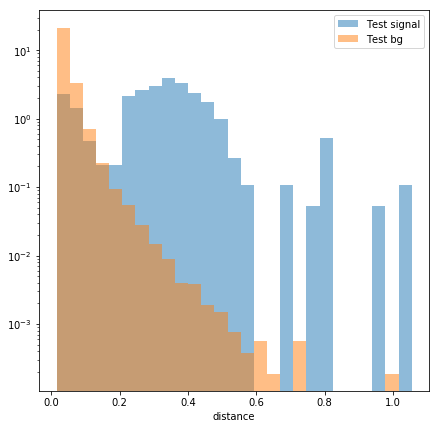

In [30]:
#bins = np.arange(0, 2, 0.01)
plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(norm_test, bins='auto', alpha=0.5, label='Test signal', normed=1, log=True)
#plt.hist(norm_train, bins, alpha=0.5, label='Train', normed=1)
plt.hist(norm_test_bg, bins, alpha=0.5, label='Test bg', normed=1)
plt.xlabel('distance')
plt.legend(loc='upper right')
plt.savefig("images/distances.png")


## ROC Curve

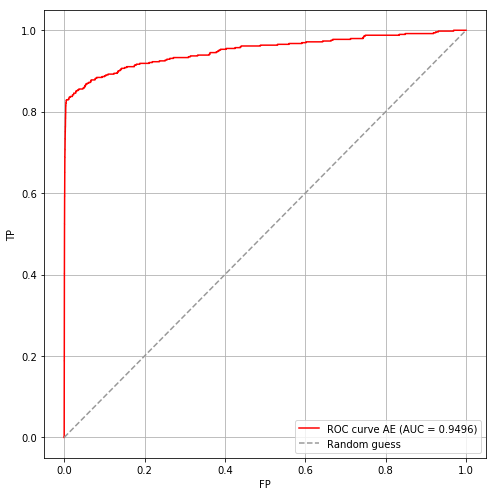

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

target = np.concatenate((np.zeros(x_train.shape[0]),np.ones(x_test_signal.shape[0])))
scores = np.concatenate((norm_test_bg,norm_test))  

plt.figure(figsize=(7, 7))
                   
fp, vp, thresholds = roc_curve(target,scores,pos_label=1)
roc_auc = auc(fp, vp)

plt.plot(fp,vp,color='red',label='ROC curve %s (AUC = %0.4f)'%('AE',roc_auc))

plt.xlabel('FP')
plt.ylabel('TP')
plt.plot([0, 1],[0, 1],
         linestyle='--',color=(0.6, 0.6, 0.6),
         label='Random guess')
#plt.plot([0, 0, 1],[0, 1, 1],color='yellow',label='Idéal')
plt.grid()
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("images/ROC.png")

### Confusion matrix

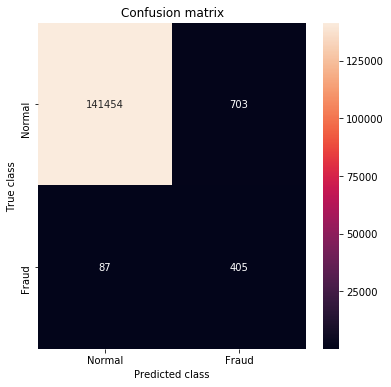

False positive rate = 0.49 %
True positive rate = 82.32 %


In [20]:
from sklearn.metrics import confusion_matrix

LABELS = ["Normal", "Fraud"]

threshold = 0.2

y_pred = [1 if e > threshold else 0 for e in scores]
conf_matrix = confusion_matrix(target, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

NN = conf_matrix[0,0]
NF = conf_matrix[0,1]
FN = conf_matrix[1,0]
FF = conf_matrix[1,1]
print('False positive rate = %.2f %%' % (NF/(NN+NF)*100))
print('True positive rate = %.2f %%' % (FF/(FN+FF)*100))


### Check output

### Show distance vs input variables

### Check variable reconstruction

Train variables: true and reco


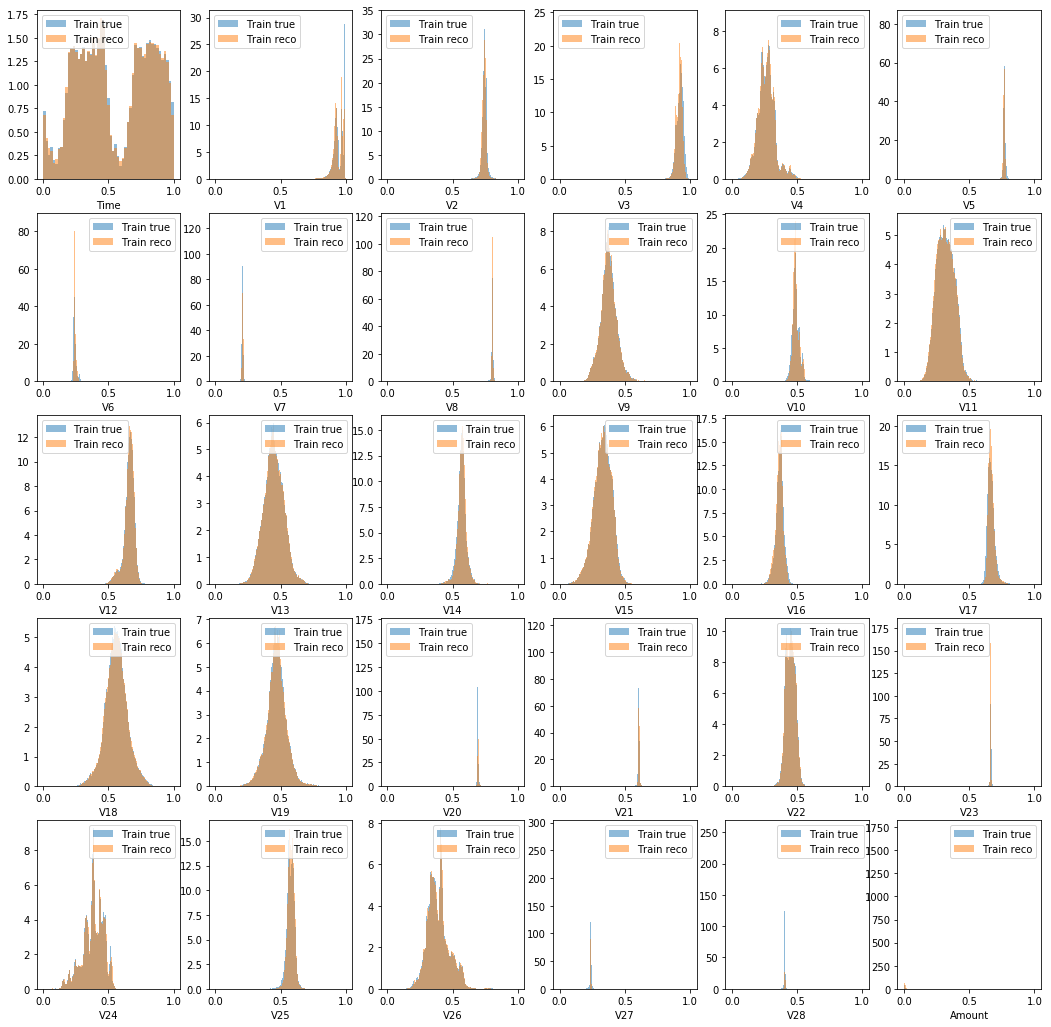

In [17]:
#bins = np.arange(0, 1, 0.01)

print("Train variables: true and reco")
plt.figure(figsize=(18, 18))
for i in range(x_test_signal.shape[1]):
    plt.subplot(5, 6, i+1)
    n, bins, patches = plt.hist(x_train[:,i], bins='auto', alpha=0.5, label='Train true', normed=1)
    n, bins, patches = plt.hist(train_output[:,i], bins, alpha=0.5, label='Train reco', normed=1)
    plt.xlabel(varname[i])
    plt.legend(loc='best')
    
plt.savefig('images/train_variables_true_reco.png')

Test variables: true and reco


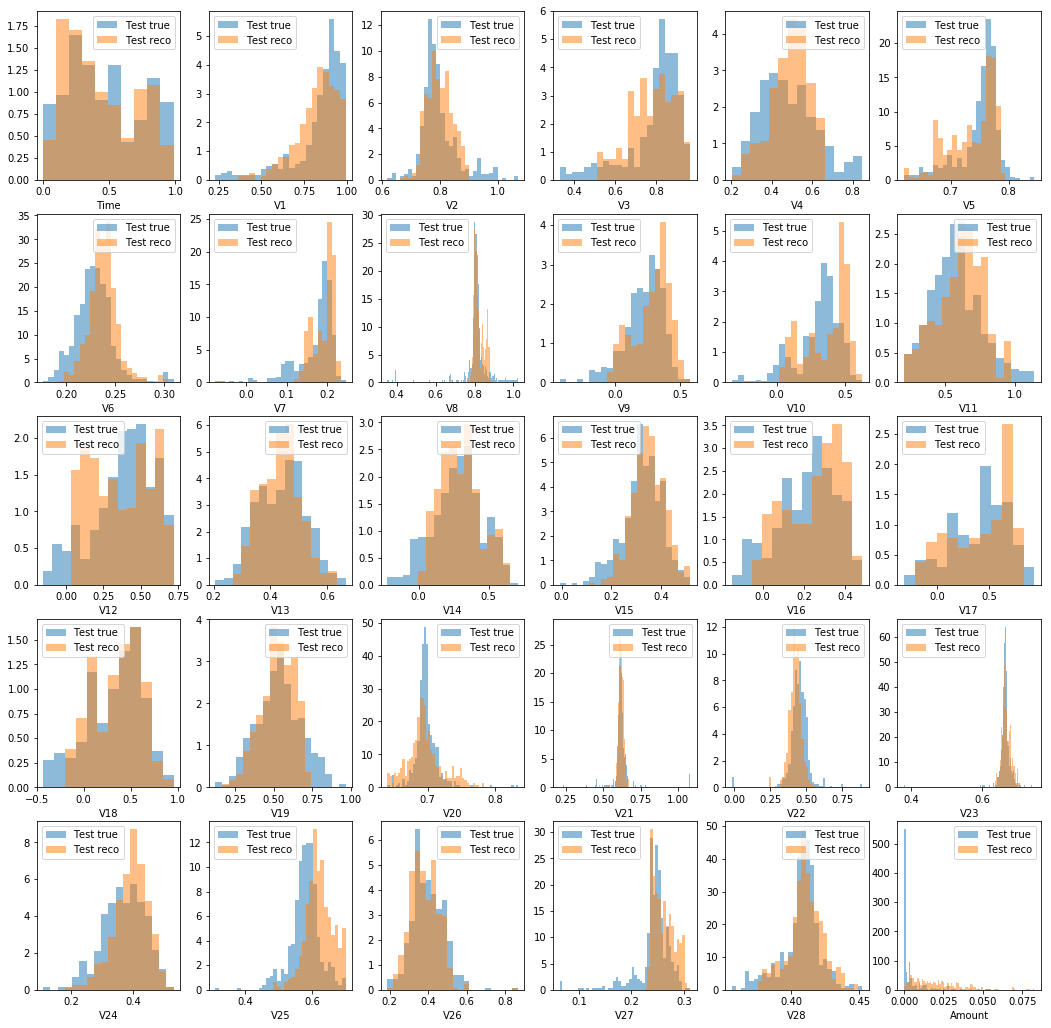

In [18]:
print("Test variables: true and reco")
plt.figure(figsize=(18, 18))
for i in range(x_test_signal.shape[1]):
    plt.subplot(5, 6, i+1)
    n, bins, patches = plt.hist(x_test_signal[:,i], bins='auto', alpha=0.5, label='Test true', normed=1)
    n, bins, patches = plt.hist(test_output[:,i], bins, alpha=0.5, label='Test reco', normed=1)
    plt.xlabel(varname[i])
    plt.legend(loc='best')
    
plt.savefig('images/test_variables_true_reco.png')

### Show distances in each mass slices

### Show impact of noise on input variable

### Tests: reconstruct corrupted data (random variables set to zero)

### Distance for random values

# Save the model for future implementations

In [19]:
#torch.save(model.state_dict(), 'models/AE_input%d_hidden%d_ne%d_bs%d_minmax_noSeLU_pytorch.pkl' % (input_dim,encoding_dim,num_epochs,batch_size))

#torch.save(model.state_dict(), 'models/AE_input%d_hidden%d_pytorch.pkl' % (input_dim,encoding_dim))
#torch.save(model.state_dict(), 'models/AE_gaussian-input%d_hidden%d_pytorch.pkl' % (input_dim,encoding_dim))

#torch.save(model.state_dict(), 'models/AE_input%d_500-500-50-500-500_noise0.1_ne%d_bs%d_minmax_noSeLU_pytorch.pkl' % (input_dim,num_epochs,batch_size))
